# Linking writing processes to writing quality

Notebook by Kyle Lacson

## I. Import Modules and Libraries

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import os
import gc
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## II. Setup directories and/or files

In [2]:
# - Setup and change base directory
base_dir = r'/kaggle/input/linking-writing-processes-to-writing-quality'
os.chdir(base_dir)
os.listdir(os.getcwd())

['sample_submission.csv',
 'test_logs.csv',
 'train_scores.csv',
 'train_logs.csv']

In [3]:
# - Importing csv files - pyarrow engine loads 2x as fast
import time
start = time.time()
for i in os.listdir(os.getcwd()):
    if i == 'sample_submission.csv':
        sample = pd.read_csv(i, engine = 'pyarrow')
    elif i == 'test_logs.csv':
        test_logs = pd.read_csv(i, engine = 'pyarrow')
    elif i == 'train_scores.csv':
        train_score = pd.read_csv(i, engine = 'pyarrow')
    elif i == 'train_logs.csv':
        train_logs = pd.read_csv(i, engine = 'pyarrow')
    else:
        print(i)
end = time.time()
print(end - start)

5.005460977554321


In [4]:
# - Creating a copy of train_logs 
train_logs_copy = train_logs.copy()

## III. Explore data

### III.i Train logs

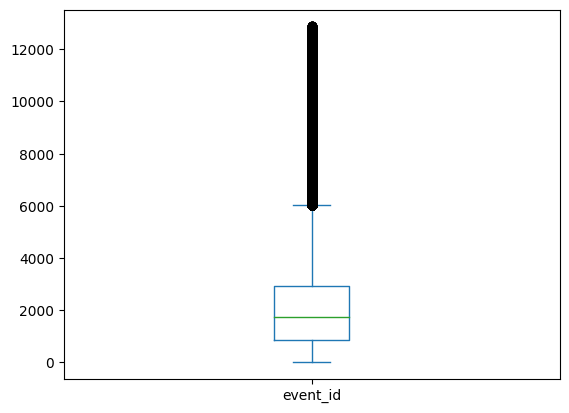

In [5]:
train_logs.event_id.plot(kind = 'box');

In [6]:
train_logs.describe(include = 'object')

,id,activity,down_event,up_event,text_change
count,8387387,8387387,8387387,8387387,8387387
unique,2465,50,131,130,4099
top,d3fef198,Input,q,q,q
freq,12876,6711310,5352915,5352388,6113973


### III.ii Text Change Column

Text change input: "q" occurs 72.89% of the time.


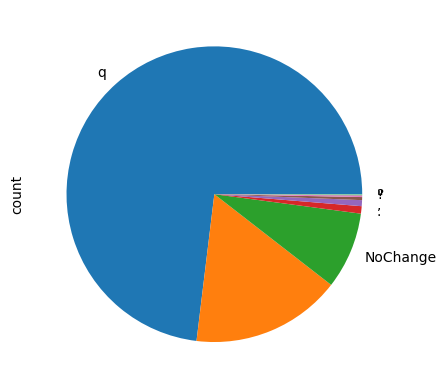

In [7]:
# - Breakdown text_change column as there are many unique values
'''
Function: Update text change column and provide a visual understanding of the column.
''' 
def text_change_column():
    train_logs.text_change.value_counts()[:10].plot(kind = 'pie');
    print(f'Text change input: "{train_logs.text_change.value_counts().index[0]}" occurs {round(train_logs.text_change.value_counts()[0]/train_logs.shape[0],4)*100}% of the time.')
    pd.options.display.float_format = '{:.3f}'.format
    text_change_series = list(train_logs.text_change.value_counts())
    text_change_percentage = list(train_logs.text_change.value_counts().map(lambda x: round(x,4) / train_logs.shape[0]))
    text_change_df = pd.DataFrame(data = {'Value_count': text_change_series, 'Percentage_of_total': text_change_percentage}, index = train_logs.text_change.value_counts().index)
    text_change_keep_df = text_change_df[text_change_df.Percentage_of_total > 0.001].style.background_gradient()
    
    # - Text_change column change
    text_change_keep_df.index
    train_logs.text_change = train_logs.text_change.map(lambda x: x if x in text_change_keep_df.index else 'Other')
    
    return train_logs

# - init text_change columns change
train_logs = text_change_column()

## III.ii Down Event and Up Event columns

In [8]:
# - Breakdown down event and up event unique values composition
'''
Function: Create a dataframe that shows the 0.1% usage of all unique values.
'''
def column_value_count(column_name):
    val_count = train_logs[column_name].value_counts()
    percentage_of_total = train_logs[column_name].value_counts().map(lambda x: x / train_logs.shape[0])
    df = pd.DataFrame(data = {'Value_count': val_count, 'Percentage_of_total': percentage_of_total}, index = train_logs[column_name].value_counts().index)
    df = df[df['Percentage_of_total'] > 0.001].style.background_gradient(cmap = 'YlOrRd') # 0.1% threshold composition
    return df

In [9]:
# # - Down event unique count breakdown 
down_event_keep_df = column_value_count('down_event')
down_event_keep_df

,Value_count,Percentage_of_total
down_event,,
q,5352915,0.638210
Space,1204406,0.143597
Backspace,961706,0.114661
Shift,333988,0.039820
ArrowRight,121333,0.014466
Leftclick,90829,0.010829
ArrowLeft,63216,0.007537
.,59428,0.007085
",",46686,0.005566


In [10]:
# - Up event unique count breakdown
up_event_keep_df = column_value_count('up_event')
up_event_keep_df

,Value_count,Percentage_of_total
up_event,,
q,5352388,0.638147
Space,1204406,0.143597
Backspace,961706,0.114661
Shift,333988,0.039820
ArrowRight,121333,0.014466
Leftclick,90829,0.010829
ArrowLeft,63216,0.007537
.,59428,0.007085
",",46686,0.005566


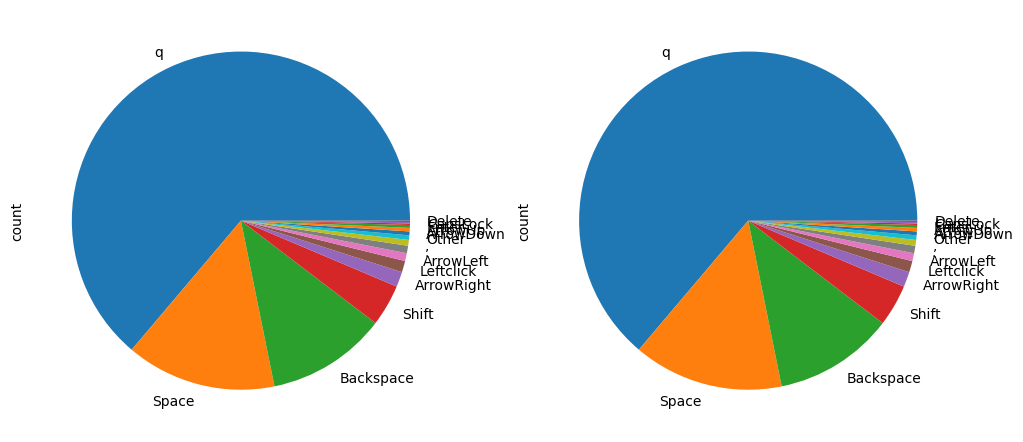

In [11]:
# - Anything below 0.1% of total inputs will be changed to other
'''
Function: Updates the up events and down events of the main dataframe.
'''
def up_down_event(): 
    new_d_event = train_logs.down_event.map(lambda x: x if x in down_event_keep_df.index else 'Other')
    new_u_event = train_logs.up_event.map(lambda x: x if x in up_event_keep_df.index else 'Other')
    fig,ax = plt.subplots(1,2, figsize = (12,12))
    new_d_event.value_counts().plot(kind = 'pie', ax = ax[0])
    new_u_event.value_counts().plot(kind = 'pie', ax = ax[1]);
    
    # update columns
    train_logs.down_event = new_d_event
    train_logs.up_event = new_u_event

    return train_logs

# init up event and down event function
train_logs = up_down_event()

In [12]:
train_logs.describe(include = 'object')

,id,activity,down_event,up_event,text_change
count,8387387,8387387,8387387,8387387,8387387
unique,2465,50,16,16,8
top,d3fef198,Input,q,q,q
freq,12876,6711310,5352915,5352388,6113973


### III.iii Activity column

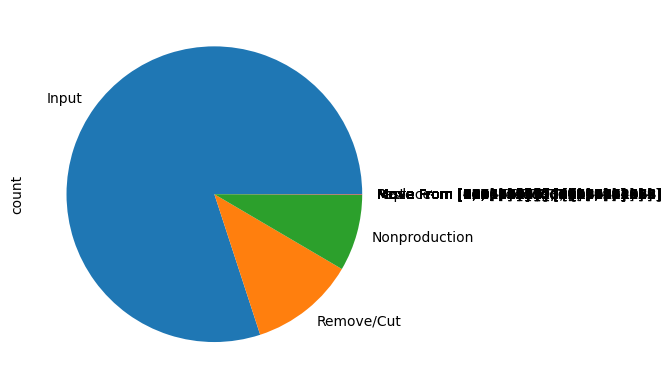

In [13]:
# - Visualize the unique activity column inputs
'''
Function: Updating activity column of dataframe.
'''
def activity_column():
    train_logs.activity.value_counts().plot(kind = 'pie');
    activity_index = train_logs.activity.value_counts()[:5].index
    train_logs.activity = train_logs.activity.apply(lambda x: x if x in activity_index else 'Other')
    
    return train_logs 

# init activity column
train_logs = activity_column()

,score
count,2471.000
mean,3.711
std,1.025
min,0.500
25%,3.000
50%,4.000
75%,4.500
max,6.000


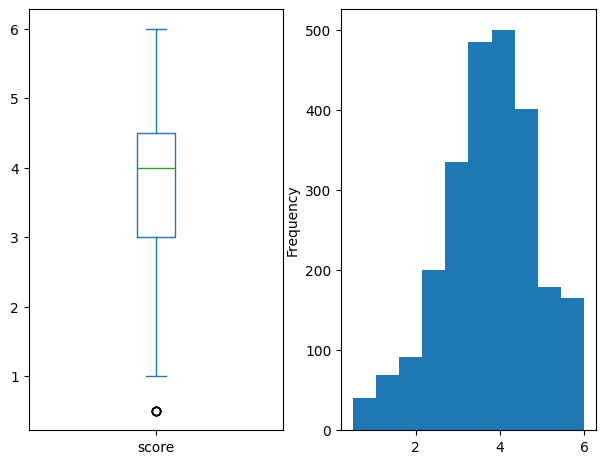

In [14]:
# - Statistics on training score
fig,ax = plt.subplots(1,2)
fig.tight_layout()
train_score.score.plot(kind = 'box', ax = ax[0], subplots = True)
train_score.score.plot(kind = 'hist', ax = ax[1], subplots = True);
train_score.describe()

### III.iv Combine scores with main dataset

In [15]:
# - Combine score with id's
'''
Function: Combines the train_log and train_score dataframes.'''
def combine_log_score():
    score_dict = train_score.set_index(keys = 'id').to_dict()['score']
    train_logs['score'] = train_logs.id.apply(lambda x: score_dict[x]).astype(np.float16)
    return train_logs

# init combine log score function 
train_logs = combine_log_score()

### III.iv Datatype changing -> Save memory space

In [16]:
# - Save memory, convert int64 dtype to int32
for i in train_logs.columns:
    if train_logs[i].dtype == np.int64:
        train_logs[i] = train_logs[i].astype(np.int32)
    elif train_logs[i].dtype == np.float16:
        train_logs[i] = train_logs[i].astype('str')
    else:
        continue

In [17]:
train_logs.isnull().sum() # no missing values

id                 0
event_id           0
down_time          0
up_time            0
action_time        0
activity           0
down_event         0
up_event           0
text_change        0
cursor_position    0
word_count         0
score              0
dtype: int64

In [18]:
train_logs.info() # datatypes has been changed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8387387 entries, 0 to 8387386
Data columns (total 12 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   id               object
 1   event_id         int32 
 2   down_time        int32 
 3   up_time          int32 
 4   action_time      int32 
 5   activity         object
 6   down_event       object
 7   up_event         object
 8   text_change      object
 9   cursor_position  int32 
 10  word_count       int32 
 11  score            object
dtypes: int32(6), object(6)
memory usage: 575.9+ MB


### IV. Feature Selection / Model Development

In [19]:
# - Prepare dataset
from sklearn.preprocessing import LabelEncoder

X = train_logs.drop(columns = 'score')
y = train_logs.score

# - Label Encoder
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

In [20]:
try:
    del train_logs
except:
    pass

In [21]:
# - Dummy variables for categorical columns
'''
Function: Returns the the training with dummy variables.
'''
def dummy_variables(X):
    X_dummies = pd.get_dummies(X.drop(columns = ['id','event_id']), drop_first = True, dtype = int)
    X_dummies['id'] = X.id
    X_dummies['event_id'] = X.event_id
    return X_dummies

# init dummy_variables function 
X_dummies = dummy_variables(X)

In [22]:
try:
    del X
except:
    pass

### IV.i Split training dataset

In [23]:
# - Split training set into training and test set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_dummies, y, test_size = 0.20, random_state = 42)

In [24]:
try:
    del X_dummies
except:
    pass

try:
    del y
except:
    pass

gc.collect()

22579

### IV.ii Feature selection 
**Citation for feature selection**: https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

In [25]:
# - Feature selection classification
from sklearn.feature_selection import SelectKBest, chi2, f_classif

def feature_best_selection(statistical_test):
    start = time.time()
    features = SelectKBest(statistical_test, k = 10) # find optimal k?
    best_features = features.fit_transform(X_train.drop(columns = ['id','event_id']),y_train) # do i need to transform this matrix?
    
    features_dict = {
    'feature_names': features.feature_names_in_,
    'feature_scores': features.scores_
    }

    df = pd.DataFrame(data = features_dict)
    
    # - Visual representation
    sorted_features = df.sort_values(by = 'feature_scores', ascending = False, axis = 0)[:10]
    fig, ax = plt.subplots(figsize = (6,6))
    sns.barplot(x = sorted_features['feature_names'], y = sorted_features['feature_scores'])
    plt.xticks(rotation = 90);
    end = time.time()
    print(f'Process time: {end - start} seconds')

In [26]:
# feature_best_selection(f_classif)

In [27]:
# feature_best_selection(chi2)

**Notes:** 
- Can explore PCA (clustering and explained component variance)
- Feature importance
- Sequential Feature Selection

## V. Model Implementation

In [28]:
# - Scale data
from sklearn.preprocessing import StandardScaler
'''
Function: Scale dataset.
'''
def scale_df(X):
    scaler = StandardScaler()
    scaler.fit(X.drop(columns = ['id','event_id']))
    X_df = pd.DataFrame(data = scaler.transform(X.drop(columns = ['id','event_id'])), columns = X.drop(columns = ['id','event_id']).columns)
#     X_df['id'] = X.id.values
#     X_df['event_id'] = X.event_id.values
    
    return X_df

# - init scaled dataframes
X_train_sc = scale_df(X_train)
X_val_sc = scale_df(X_val)

In [29]:
try:
    del X_train
except:
    pass

try:
    del X_test
except:
    pass

gc.collect()

0

In [30]:
# - Check for GPU
from torch import cuda

device = 'gpu' if cuda.is_available() else 'CPU'
device

'gpu'

### V.i Classification Models

**Citation for classification algorithms:** https://medium.com/thrive-in-ai/classification-algorithms-in-python-5f58a7a27b88

In [31]:
# - Creating a robust model classifier model
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from catboost import CatBoostClassifier # catboost only works with the T4 GPU's?
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

# - Validation set
split = int(X_train_sc.shape[0] * 0.80) # 80% training and validation set
Xtr, Xv = X_train_sc[:split], X_train_sc[split:]
ytr, yv = y_train[:split], y_train[split:]

def classification_method(train_data = X_train_sc, train_target = y_train, val_data = X_val_sc, val_target = y_val, classifier = None, params = None):
    start = time.time()
    if classifier != None:
        if params != None:
            clf = classifier(**params)
            if classifier == xgb.XGBClassifier:
                clf.fit(X = Xtr, y = ytr, eval_set = [(Xtr,ytr),(Xv,yv)], verbose = 3)
            elif classifier == CatBoostClassifier:
                clf.fit(X = Xtr, y = ytr, eval_set = (Xv,yv), verbose = 50, early_stopping_rounds = 25)
        else:
            clf.classifier()
            clf.fit(train_data, train_target)
    
        clf_predict = clf.predict(val_data)

        # metrics 
        acc = accuracy_score(val_target, clf_predict)
#         mean_acc = cross_val_score(estimator = clf, X = val_data, y = val_target, cv = 3, n_jobs = -1, verbose = 1, error_score = 'raise').mean()
        try:
            l_loss = log_loss(val_target, clf_predict)
        except:
            pass 
            
        print(f'{str(classifier)}')

        # confusion matrix
        cm = confusion_matrix(val_target, clf_predict, labels = clf.classes_)
        disp = ConfusionMatrixDisplay(cm, display_labels = clf.classes_)
        disp.plot()
        plt.show()
        print(classification_report(val_target,clf_predict))
        print('\n','*'*75,'\n')
        print(f'Accuracy: {acc}')
        try:
            print(f'Cross Validation Score - mean: {mean_acc}')
        except:
            pass
        try:
            print(f'Log Loss: {l_loss}')
        except:
            pass
            
        end = time.time()
        print('\n','*'*75,f'\nProcess Time: {end - start}')
    
    elif classifier == None:
        end = time.time()
        print('Please input a classifier.',f'\nProcess time: {end - start} seconds')
        
    return clf

In [32]:
# # - XGBClassifier - w/GPU
# params = {
#     'verbosity': 3,
#     'n_jobs': -1,
#     'random_state': 42,
#     'device': device,
#     'early_stopping_rounds': 25
# }

# xgb_clf = classification_method(classifier = xgb.XGBClassifier, params = params)

In [33]:
# # - Catboost - with GPU
# params = {
#     'random_seed': 42,
#     'task_type': 'GPU',
#     'verbose': True,
#     'allow_writing_files': False
# }
# cb_clf = classification_method(classifier = CatBoostClassifier, params = params)

In [34]:
# classification_model(classifier = KNeighborsClassifier)

In [35]:
# classification_model(classifier = GaussianNB)

### V.ii Artificial Neural Network

In [36]:
# - Datasets 
'''
Training Data: 
X_train_sc 
y_train

Validation Data:
X_val_sc
y_val

Validation Training Evaluation Set:
Xtr
ytr

Validation Test Evaluation Set:
Xv
yv
'''

'\nTraining Data: \nX_train_sc \ny_train\n\nValidation Data:\nX_val_sc\ny_val\n\nValidation Training Evaluation Set:\nXtr\nytr\n\nValidation Test Evaluation Set:\nXv\nyv\n'

In [37]:
# - Tensorflow 
import tensorflow as tf 
from tensorflow.keras import metrics
tf.config.list_physical_devices()

callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
input_shape = X_train_sc.shape[1]
output_shape = len(np.unique(y_train))
opt = tf.keras.optimizers.Adam(learning_rate = 0.0015)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
epochs = 225
batch_size = 5000

def nn_model(input_shape = input_shape, output_shape = output_shape, optimizer_func = opt, loss_func = loss, epochs = epochs, batch_size = batch_size):

    tf.random.set_seed(42)

    # - model input
    model_input = tf.keras.Input(shape = (input_shape), name = 'input_layer')
        
    #- hidden layer
    dense1 = tf.keras.layers.Dense(units = 128, activation = 'relu', name = 'dense_layer_1')(model_input)
    drop_out1 = tf.keras.layers.Dropout(rate = 0.2, seed = 42, name = 'dropout_layer_1')(dense1)
    dense2 = tf.keras.layers.Dense(units = 256, activation = 'relu', name = 'dense_layer_2')(drop_out1)
    drop_out2 = tf.keras.layers.Dropout(rate = 0.2, seed = 42, name = 'dropout_layer_2')(dense2)
    dense3 = tf.keras.layers.Dense(units = 512, activation = 'relu', name = 'dense_layer_3')(drop_out2)
    drop_out3 = tf.keras.layers.Dropout(rate = 0.2, seed = 42, name = 'dropout_layer_3')(dense3)
    dense4 = tf.keras.layers.Dense(units = 256, activation = 'relu', name = 'dense_layer_4')(drop_out3)
    drop_out4 = tf.keras.layers.Dropout(rate = 0.2, seed = 42, name = 'dropout_layer4')(dense4)
    dense5 = tf.keras.layers.Dense(units = 128, activation = 'relu', name = 'dense_layer_5')(drop_out4)

#     # - hidden layer
#     dense1 = tf.keras.layers.Dense(64, 'relu')(model_input)
#     dense2 = tf.keras.layers.Dense(128, 'relu')(dense1)
#     dense3 = tf.keras.layers.Dense(64, 'relu')(dense2)

    # - output layer
    output_layer = tf.keras.layers.Dense(output_shape, 'softmax', name = 'output_layer')(dense5)

    model = tf.keras.Model(inputs = model_input, outputs = output_layer,name = 'model')

    model.compile(optimizer = optimizer_func, loss = loss_func, metrics = ['accuracy'])

    history = model.fit(x = X_train_sc, y = y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.2, callbacks = callback)
    
    fig, ax = plt.subplots(1,2)
    
    # - crossentropy loss
    sns.lineplot(x = range(len(history.history['loss'])), y = history.history['loss'], ax = ax[0], label = 'training')
    sns.lineplot(x = range(len(history.history['val_loss'])), y = history.history['val_loss'], ax = ax[0], label = 'validation')
    ax[0].set_title('Crossentropy Loss')
    
    # - accuracy
    sns.lineplot(x = range(len(history.history['accuracy'])), y = history.history['accuracy'], ax = ax[1], label = 'training')
    sns.lineplot(x = range(len(history.history['val_accuracy'])), y = history.history['val_accuracy'], ax = ax[1], label = 'validation')
    ax[0].set_title('Accuracy')
    
    plt.show()
    
    loss_eval, acc_eval = model.evaluate(X_val_sc, y_val, batch_size = batch_size)
    print(f'Final loss value: {loss_eval}\nFinal accuracy: {acc_eval}')
    
    return model

# lr = 0.0015, batch_size = 2500 acc = 0.377 percent

Epoch 1/225
1074/1074 [==============================] - 15s 8ms/step - loss: 1.8870 - accuracy: 0.2716 - val_loss: 1.8234 - val_accuracy: 0.2944
Epoch 2/225
1074/1074 [==============================] - 7s 7ms/step - loss: 1.8237 - accuracy: 0.2929 - val_loss: 1.7725 - val_accuracy: 0.3121
Epoch 3/225
1074/1074 [==============================] - 7s 7ms/step - loss: 1.7909 - accuracy: 0.3053 - val_loss: 1.7311 - val_accuracy: 0.3302
Epoch 4/225
1074/1074 [==============================] - 7s 7ms/step - loss: 1.7674 - accuracy: 0.3143 - val_loss: 1.7037 - val_accuracy: 0.3401
Epoch 5/225
1074/1074 [==============================] - 7s 7ms/step - loss: 1.7498 - accuracy: 0.3207 - val_loss: 1.6800 - val_accuracy: 0.3504
Epoch 6/225
1074/1074 [==============================] - 7s 7ms/step - loss: 1.7369 - accuracy: 0.3256 - val_loss: 1.6600 - val_accuracy: 0.3562
Epoch 7/225
1074/1074 [==============================] - 7s 7ms/step - loss: 1.7262 - accuracy: 0.3293 - val_loss: 1.6483 - val_a

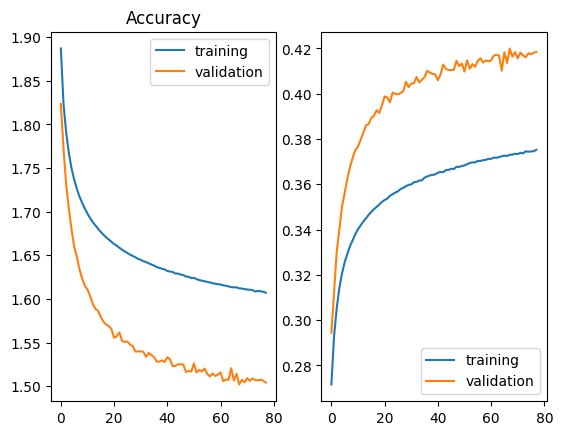

336/336 [==============================] - 1s 3ms/step - loss: 1.6532 - accuracy: 0.3765
Final loss value: 1.6531728506088257
Final accuracy: 0.37648898363113403


In [38]:
model = nn_model()

In [39]:
gc.collect()

2849

**Note:** Class Imabalance may be effecting classification...

In [40]:
def model2():
    
    epoch = 100
    
    tf.random.set_seed(42)
    model_input = tf.keras.Input(shape = (X_train_sc.shape[1],))
    dense1 = tf.keras.layers.Dense(512, 'relu')(model_input)
    dense2 = tf.keras.layers.Dense(512, 'relu')(dense1)
    dense3 = tf.keras.layers.Dense(512, 'relu')(dense2)
    output_layer = tf.keras.layers.Dense(len(np.unique(y_train)), 'softmax')(dense3)
    
    model = tf.keras.Model(inputs = model_input, outputs = output_layer)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
    
    history = model.fit( X_train_sc,y_train, batch_size = 10000, epochs = epoch, validation_split = 0.2, callbacks = callback)
                                         
    loss, acc = model.evaluate(X_val_sc, y_val, batch_size = 10000)
                     
    fig,ax = plt.subplots()
    ax.plot(range(len(history.history['loss'])), history.history['loss'], color = 'blue', label = 'validation')
    ax.plot(range(len(history.history['val_loss'])), history.history['val_loss'], color = 'red', marker = '*', label = 'validation')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    
    ax2 = ax.twinx()
    ax2.plot(range(len(history.history['accuracy'])), history.history['accuracy'], color = 'blue', label = 'training')
    ax2.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], color = 'red', marker = '*', label = 'validation')
    ax2.set_ylabel('Accuracy')
    
    ax.legend(loc = 'upper center')
    ax2.legend(loc = 'upper center')
    
    return loss, acc

In [41]:
# model2()

In [42]:
gc.collect()

7796

In [43]:
# ### V.iii. Neural Network Hypertuning
# import tensorflow as tf
# from tensorflow import keras
# import keras_tuner as kt

# def model_builder(hp):
#     model = keras.Sequential()
#     hp_unit = hp.Int('units', min_value = 64, max_value = 1028, step = 64)
    
#     # - hidden layers
#     model.add(keras.layers.Dense(units = hp_unit, activation = 'relu'))
#     if hp.Boolean('dropout'):
#         model.add(keras.layers.Dropout(rate = 0.2))
#     model.add(keras.layers.Dense(units = hp_unit, activation = 'relu'))
#     if hp.Boolean('dropout'):
#         model.add(keras.layers.Dropout(rate = 0.2))
#     model.add(keras.layers.Dense(units = hp_unit, activation = 'relu'))
#     model.add(keras.layers.Dense(units = len(np.unique(y_train))))
    
#     # - compiler
#     hp_learning_rate = hp.Float('lr', min_value = 1e-4, max_value = 1e-2, sampling = 'log')
#     model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
#                  loss = 'sparse_categorical_crossentropy',
#                  metrics = 'accuracy')
    
#     return model

# # - Checking to see if model was built correctly
# model_builder(kt.HyperParameters()) # model was successfully built

# # - Starting the search
# os.chdir(r'/kaggle/working/') # need to change to a directory to write files
# tuner = kt.RandomSearch(hypermodel = model_builder,
#                         objective = 'val_accuracy',
#                         seed = 42,
#                         max_trials = 4,
#                         executions_per_trial = 2,
#                         directory = 'random_search',
#                         overwrite = True,
#                         project_name = 'hp_tune'
#                        )

# tuner.search_space_summary()

In [44]:
# tuner.search(X_train_sc, y_train, epochs = 10, batch_size = 15000, validation_split = 0.2)

## Submission: